# Learning story with Dmitry


### 0. Imports (Just run, don't read)

In [2]:
import torch as t
from gappy import gap
from gappy.gapobj import GapObj
from named_groups import *
from train import Parameters
from torch.utils.data import Dataset
from utils import *
from named_groups import *
import dataclasses
from dataclasses import dataclass
from jaxtyping import Float, Int, jaxtyped
from typing import Optional, Callable, Union, List, Tuple
from model import normal
from torch.utils.data import DataLoader, Dataset, RandomSampler
from utils import get_cross_entropy, get_accuracy
import torch.nn.functional as F
from tqdm.notebook import tqdm

import itertools

In [3]:
mps_device = t.device("mps")

In [435]:
class MLP(t.nn.Module):
    def __init__(self, params, dimensions):
        super().__init__()

        self.params = params
        self.N = len(params.group)
        self.dimensions = dimensions
        self.embedding_left = t.nn.Embedding(self.N, dimensions["embedding"])

        self.embedding_right = t.nn.Embedding(self.N, dimensions["embedding"])

        self.linear = t.nn.Linear(
            dimensions["embedding"], dimensions["linear"], bias=False
        )
        self.linear_post_activation = t.nn.Linear(
            dimensions["linear"],
            dimensions["embedding"],
            bias=False,
        )

        d_unembed = (
            dimensions["linear"]
            if params.intermediate == "pure"
            else dimensions["embedding"]
        )

        self.unembedding = t.nn.Linear(d_unembed, self.N, bias=True)

        if params.embedding_tied:
            self.embedding_right.weight = self.embedding_left.weight

        if params.unembedding_tied:
            assert (
                params.embedding_tied
            ), "Unembedding can only be tied if embedding is tied"
            assert (
                d_unembed == dimensions["embedding"]
            ), "Unembedding can only be tied if dimensions match"

            self.unembedding.weight = self.embedding_left.weight.T

        if params.activation_function == "relu":
            self.act = t.nn.ReLU()
        elif params.activation_function == "gelu":
            self.act = t.nn.GELU()
        elif params.activation_function == "quad":
            self.act = lambda x: x**2
        else:
            raise ValueError(f"Unknown activation function {params.activation}")

        self.intermediate = 0

    def forward(
        self, a: Int[t.Tensor, "batch_size entries"]
    ) -> Float[t.Tensor, "batch_size d_vocab"]:

        a_1, a_2 = a[..., 0], a[..., 1]

        x_1 = self.embedding_left(a_1)  # shape (batch_size, embedding)
        x_2 = self.embedding_right(a_2)

        return self.intermediate_layer(x_1, x_2)

    def freeze_all(self):
        for param in self.parameters():
            param.requires_grad = False

    def unfreeze_all(self):
        for param in self.parameters():
            param.requires_grad = True

    def freeze(self, part: str, indices: Optional[List[int]] = None):
        if indices is None:
            indices = list(range(self.dimensions["embedding"]))
        for i in indices:
            if part == "embedding_left":
                self.embedding_left.weight.data[i].requires_grad = False
            elif part == "embedding_right":
                self.embedding_right.weight.data[i].requires_grad = False
            elif part == "unembedding":
                self.unembedding.weight.data[:, i].requires_grad = False

    def unfreeze(self, part: str, indices: Optional[List[int]] = None):
        if indices is None:
            indices = list(range(self.dimensions["embedding"]))
        for i in indices:
            if part == "embedding_left":
                self.embedding_left.weight.data[i].requires_grad = True
            elif part == "embedding_right":
                self.embedding_right.weight.data[i].requires_grad = True
            elif part == "unembedding":
                self.unembedding.weight.data[:, i].requires_grad = True

    def freeze_linear(self):
        for param in self.linear.parameters():
            param.requires_grad = False

    def unfreeze_linear(self):
        for param in self.linear.parameters():
            param.requires_grad = True

    def get_neurons(self, squeeze=False) -> Float[t.Tensor, "instances d_vocab hidden"]:
        """
        Left and right pre-activation neuron weights
        """
        lneurons = einops.einsum(
            self.embedding_left.weight.data,
            self.linear.weight.data,
            " d_vocab embed_dim,  hidden embed_dim-> d_vocab hidden",
        ).detach()
        rneurons = einops.einsum(
            self.embedding_right.weight.data,
            self.linear.weight.data,
            " d_vocab embed_dim,  hidden embed_dim ->  d_vocab hidden",
        ).detach()
        uneurons = self.unembedding.weight.data.detach()

        if squeeze:
            lneurons, rneurons, uneurons = (
                lneurons.squeeze(0),
                rneurons.squeeze(0),
                uneurons.squeeze(0),
            )

        return lneurons, rneurons, uneurons

    def intermediate_layer(
        self,
        x: Float[t.Tensor, "batch_size embed_dim"],
        y: Float[t.Tensor, "batch_size embed_dim"],
    ) -> Float[t.Tensor, "batch_size d_vocab"]:

        d = self.dimensions["embedding"]

        if self.params.intermediate == "real_multiplication":
            real_prod = x * y  # shape (batch_size, embedding)
            return self.unembedding(real_prod)

        if self.params.intermediate == "complex_multiplication":
            assert (
                d % 2 == 0
            ), "Embedding dimension must be even for complex multiplication"

            x_complex = einops.rearrange(
                x, "batch (embed_dim c) -> batch embed_dim c", c=2
            )
            y_complex = einops.rearrange(
                y, "batch (embed_dim c) -> batch embed_dim c", c=2
            )
            complex_prod = t.zeros_like(x_complex)

            complex_prod[..., 0] = (
                x_complex[..., 0] * y_complex[..., 0]
                - x_complex[..., 1] * y_complex[..., 1]
            )

            complex_prod[..., 1] = (
                x_complex[..., 0] * y_complex[..., 1]
                + x_complex[..., 1] * y_complex[..., 0]
            )

            # reshape back to original shape

            complex_prod_flat = einops.rearrange(
                complex_prod, "batch embed_dim c -> batch (embed_dim c)"
            )

            return self.unembedding(complex_prod_flat)

        if self.params.intermediate == "quaterionic multiplication":
            assert (
                d % 4 == 0
            ), "Embedding dimension must be divisible by 4 for quaterionic multiplication"
            x_quat = einops.rearrange(
                x, "batch (embed_dim c) -> batch embed_dim c", c=4
            )
            y_quat = einops.rearrange(
                y, "batch (embed_dim c) -> batch embed_dim c", c=4
            )
            quat_prod = t.zeros_like(x_quat)
            # TODO: check this again
            quat_prod[..., 0] = (
                x_quat[..., 0] * y_quat[..., 0]
                - x_quat[..., 1] * y_quat[..., 1]
                - x_quat[..., 2] * y_quat[..., 2]
                - x_quat[..., 3] * y_quat[..., 3]
            )
            quat_prod[..., 1] = (
                x_quat[..., 0] * y_quat[..., 1]
                + x_quat[..., 1] * y_quat[..., 0]
                + x_quat[..., 2] * y_quat[..., 3]
                - x_quat[..., 3] * y_quat[..., 2]
            )
            quat_prod[..., 2] = (
                x_quat[..., 0] * y_quat[..., 2]
                - x_quat[..., 1] * y_quat[..., 3]
                + x_quat[..., 2] * y_quat[..., 0]
                + x_quat[..., 3] * y_quat[..., 1]
            )
            quat_prod[..., 3] = (
                x_quat[..., 0] * y_quat[..., 3]
                + x_quat[..., 1] * y_quat[..., 2]
                - x_quat[..., 2] * y_quat[..., 1]
                + x_quat[..., 3] * y_quat[..., 0]
            )

            # reshape back to original shape

            quat_prod_flat = einops.rearrange(
                quat_prod, "batch embed_dim c -> batch (embed_dim c)"
            )

            return self.unembedding(quat_prod_flat)

        if self.params.intermediate == "pure":

            hidden = self.linear(x + y)
            hidden_post_act = self.act(hidden)

            out = self.unembedding(hidden_post_act)

        if self.params.intermediate == "spiral":

            hidden = self.linear(x + y)
            hidden_post_act = self.act(hidden)

            hidden_post_act = self.linear_post_activation(hidden_post_act)
            out = self.unembedding(hidden_post_act)

        return out

    def fourier_circle(
        self,
        weights: Float[t.Tensor, "d_vocab embed_dim"],
        title: str = "window_projection",
        fname: str = "window_projection.png",
    ):

        from matplotlib.colors import Normalize

        from matplotlib.cm import ScalarMappable

        def get_dft_matrix(P):
            cos = t.zeros((P, P))
            sin = t.zeros((P, P))
            for i in range(P):
                for j in range(P):
                    theta = t.tensor(2 * t.pi * i * j / P)
                    cos[i, j] = t.cos(theta)
                    sin[i, j] = t.sin(theta)
            return cos, sin

        def get_magnitude_modes(weights, P):
            cos, sin = get_dft_matrix(P)
            c1, s1 = cos @ weights, sin @ weights
            return t.sqrt(t.sum(c1**2 + s1**2, dim=-1))

        def get_weights_modes(weights, P):
            cos, sin = get_dft_matrix(P)
            c1 = cos @ (weights @ weights.T)
            s1 = sin @ (weights @ weights.T)
            return c1, s1

        P = self.N

        c1, s1 = get_weights_modes(weights, P)
        mags = get_magnitude_modes(weights, P)
        n_plots = (P // 2) + 1
        num_cols = int(math.ceil(math.sqrt(n_plots)))
        num_rows = int(math.ceil(n_plots / num_cols))
        colormap = plt.cm.rainbow
        plt.figure(figsize=(num_cols * 2, num_rows * 2))
        colors = [colormap(i) for i in np.linspace(0, 1, P)]
        for mode in range(n_plots):
            cos = c1[mode]
            sin = s1[mode]
            plt.subplot(num_rows, num_cols, mode + 1)
            color_idx = [(i * mode) % P for i in range(P)]
            color_for_mode = [colors[idx] for idx in color_idx]
            plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
            plt.title(f"Mode {mode} {mags[mode]:.4f}", fontsize=8)
        plt.suptitle(title)
        norm = Normalize(vmin=0, vmax=P)
        sm = ScalarMappable(cmap=colormap, norm=norm)
        cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
        plt.colorbar(sm, cax=cbar_ax)
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig(fname)
        plt.close()

In [66]:
x, y = t.rand(3, 8), t.rand(3, 8)

x_complex = einops.rearrange(x, "batch (embed_dim c) -> batch embed_dim c", c=2)
y_complex = einops.rearrange(y, "batch (embed_dim c) -> batch embed_dim c", c=2)
complex_prod = t.zeros_like(x_complex)

complex_prod[..., 0] = (
    x_complex[..., 0] * y_complex[..., 0] - x_complex[..., 1] * y_complex[..., 1]
)

complex_prod[..., 1] = (
    x_complex[..., 0] * y_complex[..., 1] + x_complex[..., 1] * y_complex[..., 0]
)

# reshape back to original shape
complex_prod_2 = einops.rearrange(
    complex_prod, "batch embed_dim c -> batch (embed_dim c)"
)

In [437]:
class GroupDataBasic(Dataset):
    def __init__(self, group: Group, train_frac: float = 1.0):
        self.group = group
        self.N = len(self.group)

        self.group_set = group.cayley_set()

        train_set = self.group_set

        self.train_data = random_frac(train_set, train_frac)
        if train_frac < 1.0:
            print(
                f"Taking random subset:", frac_str(len(self.train_data), len(train_set))
            )
        print(f"Train set size: {frac_str(len(self.train_data), self.N**2)}")

    def __getitem__(self, idx):
        return (
            t.tensor([self.train_data[idx][0], self.train_data[idx][1]]),
            self.train_data[idx][2],
        )

    def __len__(self):
        return len(self.train_data)

    def frequency_histogram(self):
        self.distribution = [x[2] for x in self.train_data]
        frequency_count = Counter(self.distribution)
        x = list(frequency_count.keys())
        y = list(frequency_count.values())

        sorted_pairs = sorted(zip(x, y))
        x_sorted, y_sorted = zip(*sorted_pairs)
        plt.figure(figsize=(10, 6))
        plt.bar(x_sorted, y_sorted)

        plt.xlabel("Integers")
        plt.ylabel("Frequency")
        plt.title("Frequency Plot of Integers")

In [438]:
@t.no_grad()
def test_loss_and_acc(
    clusters,
    params,
) -> dict[str, Float[t.Tensor, "instance"]]:
    """Create all possible pairs (x,y) and return loss and accuracy for all groups in group_dataset."""
    N = len(params.group)
    test_inputs = t.tensor(list(product(range(N), repeat=2)), device=mps_device)
    group = params.group
    logits = sum(
        [clusters[i](test_inputs) for i in range(params.cluster_count)]
    ).unsqueeze(1)

    labels = einops.rearrange(group.cayley_table, "a b -> (a b)").to(mps_device)

    loss = get_cross_entropy(logits, labels, return_std=False)
    accuracy = get_accuracy(logits, labels)
    # Don't add group name to wandb logs; it makes plot searching less convenient
    # Instead store group names in wandb config (in train.py)

    # loss_dict[f"G{i}_loss_{group.name}"] = loss
    # loss_dict[f"G{i}_acc_{group.name}"] = accuracy

    return (loss, accuracy)


def get_accuracy_train(
    logits: Float[t.Tensor, "batch vocab"], labels: Int[t.Tensor, "batch"]
) -> Float[t.Tensor, ""]:
    """
    Compute instance-wise accuracy of model.
    """
    return (logits.argmax(-1) == labels).sum(dim=0) / labels.shape[0]

In [441]:
@dataclass
class ParametersBasic:
    group: Group = gapS(5)
    activation_function: str = "relu"  # relu, gelu, quad
    embed_dimensions: Int[tuple, ""] = (128,)
    hidden_dimensions: Int[tuple, ""] = (128,)
    cluster_count = len(embed_dimensions)
    batch_size: int = 64
    batched: bool = False  # if false, batch is entire data set
    replacement: bool = False
    weight_decay: float = 2e-4
    lr: float = 1e-2
    beta1: float = 0.9
    beta2: float = 0.98
    train_frac: float = 0.4
    spiral: bool = False
    intermediate: str = (
        "pure"  # pure, real_multiplication, complex_multiplication, quaterionic_multiplication, spiral
    )
    embedding_tied: bool = False
    unembedding_tied: bool = False

In [440]:
class MLPTrainer:
    def __init__(self, params: ParametersBasic) -> None:

        self.loss_dict = {
            "test_loss": [],
            "train_loss": [],
            "test_accuracy": [],
            "train_accuracy": [],
        }

        self.group = params.group
        self.params = params

        self.d = [
            {
                "embedding": params.embed_dimensions[i],
                "linear": params.hidden_dimensions[i],
            }
            for i in range(params.cluster_count)
        ]

        self.clusters = [
            MLP(params, self.d[i]).to(mps_device) for i in range(params.cluster_count)
        ]

        self.group_dataset = GroupDataBasic(
            group=params.group, train_frac=params.train_frac
        )

    def train(self, epochs=1):

        if not self.params.batched:
            batch_size = len(self.group_dataset)
        else:
            batch_size = self.params.batch_size

        train_loader = DataLoader(
            dataset=self.group_dataset,
            batch_size=batch_size,
            # shuffle=True,
            drop_last=True,
        )

        optimizer = t.optim.Adam(
            itertools.chain.from_iterable(
                [cluster.parameters() for cluster in self.clusters]
            ),
            weight_decay=self.params.weight_decay,
            lr=self.params.lr,
            betas=[self.params.beta1, self.params.beta2],
        )
        for epoch in tqdm(range(epochs)):
            with t.no_grad():
                test_loss, test_acc = test_loss_and_acc(self.clusters, self.params)
                self.loss_dict["test_loss"].append(test_loss.cpu().detach())
                self.loss_dict["test_accuracy"].append(test_acc.cpu().detach())
            for batch in train_loader:
                optimizer.zero_grad()
                a, y = batch
                a = a.to(mps_device)
                y = y.to(mps_device)
                y_pred = sum([cluster(a) for cluster in self.clusters])
                loss = F.cross_entropy(y_pred, y)
                self.loss_dict["train_loss"].append(loss.cpu().detach())
                self.loss_dict["train_accuracy"].append(
                    get_accuracy_train(y_pred, y).cpu().detach()
                )
                loss.backward()
                optimizer.step()

    def plot_loss(self, train_plot=True, test_plot=True) -> plt.Figure:
        fig, ax = plt.subplots()
        if train_plot:
            ax.plot(self.loss_dict["train_loss"], label="train_loss")
        if test_plot:
            ax.plot(self.loss_dict["test_loss"], label="test_loss")
        ax.legend()
        plt.show()
        return fig

    def plot_accuracy(self, train_plot=True, test_plot=True) -> plt.Figure:
        fig, ax = plt.subplots()
        if train_plot:
            ax.plot(self.loss_dict["train_accuracy"], label="train_accuracy")
        if test_plot:
            ax.plot(self.loss_dict["test_accuracy"], label="test_accuracy")
        ax.legend()
        plt.show()
        return fig

    def get_neurons_cluster(self) -> list:
        return [cluster.get_neurons() for cluster in self.clusters]

    def get_irrep_basis(self, verbose=False) -> dict:
        irreps = self.group.get_real_irreps(verbose=verbose)

        # Get orthogonal basis for each irrep
        irrep_bases = dict()
        for name, irrep in irreps.items():
            irrep = einops.rearrange(irrep, "N d1 d2 -> N (d1 d2)")
            irrep = irrep.to(mps_device)
            U, S, V = t.svd(irrep)
            nonzero = S > 1e-5
            irrep_bases[name] = U[:, nonzero]

            if verbose:
                # Dimension of subspace spanned by each irrep
                for k, v in irrep_bases.items():
                    print(k, v.shape)
        return irrep_bases

    def irrep_neurons_expl_max(self):

        clusters_expl = []

        for cluster in self.clusters:
            lneurons, rneurons, uneurons = cluster.get_neurons(squeeze=True)
            irrep_bases = self.get_irrep_basis()

            # Proportion of variance explained by each irrep, for each neuron
            lexpl, rexpl, uexpl = dict(), dict(), dict()

            for name, basis in irrep_bases.items():
                lexpl[name] = (basis.H @ lneurons).norm(dim=0) ** 2 / (
                    lneurons.norm(dim=0) ** 2 + 1e-8
                )
                rexpl[name] = (basis.H @ rneurons).norm(dim=0) ** 2 / (
                    rneurons.norm(dim=0) ** 2 + 1e-8
                )
                uexpl[name] = (basis.H @ uneurons).norm(dim=0) ** 2 / (
                    uneurons.norm(dim=0) ** 2 + 1e-8
                )

            lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)
            rexpl_max, rirrep = t.stack(list(rexpl.values()), dim=0).max(dim=0)
            uexpl_max, uirrep = t.stack(list(uexpl.values()), dim=0).max(dim=0)

            clusters_expl.append(
                {
                    "lexpl_max": lexpl_max,
                    "lirrep": lirrep,
                    "rexpl_max": rexpl_max,
                    "rirrep": rirrep,
                    "uexpl_max": uexpl_max,
                    "uirrep": uirrep,
                    "lexpl": lexpl,
                    "rexpl": rexpl,
                    "uexpl": uexpl,
                }
            )

            to_P = lambda basis: basis @ basis.H

            ln_proj = t.stack(
                [
                    to_P(list(irrep_bases.values())[lirrep[i]]) @ lneurons[:, [i]]
                    for i in range(lneurons.shape[1])
                ],
                dim=1,
            ).squeeze(-1)
            rn_proj = t.stack(
                [
                    to_P(list(irrep_bases.values())[rirrep[i]]) @ rneurons[:, [i]]
                    for i in range(rneurons.shape[1])
                ],
                dim=1,
            ).squeeze(-1)
            un_proj = t.stack(
                [
                    to_P(list(irrep_bases.values())[uirrep[i]]) @ uneurons[:, [i]]
                    for i in range(uneurons.shape[1])
                ],
                dim=1,
            ).squeeze(-1)

        return clusters_expl

    def print_expl_clusters(self, cluster_id=0, norm_thresh=0):
        lneurons, rneurons, uneurons = self.clusters[cluster_id].get_neurons(
            squeeze=True
        )

        cluster_expl_max = self.irrep_neurons_expl_max()[cluster_id]
        for name, neurons, expl in [
            ("left", lneurons, cluster_expl_max["lexpl_max"]),
            ("right", rneurons, cluster_expl_max["rexpl_max"]),
            ("unembed", uneurons, cluster_expl_max["uexpl_max"]),
        ]:

            z = t.where(neurons.norm(dim=0) > norm_thresh)

            plt.hist(expl[z].tolist())
            plt.title(f"{name} neurons: variance explained by best irrep")
            plt.show()

    def irrep_idx_dict(
        self, thresh=0.95, norm_thresh=1.0, cluster_id=0, neuron_type="left"
    ):
        lneurons, rneurons, uneurons = self.clusters[cluster_id].get_neurons(
            squeeze=True
        )

        irreps = self.group.get_real_irreps()

        cluster_expl = self.irrep_neurons_expl_max()[cluster_id]
        if neuron_type == "left":
            expl = cluster_expl["lexpl"]
            neurons = lneurons
        elif neuron_type == "right":
            expl = cluster_expl["rexpl"]
            neurons = rneurons
        elif neuron_type == "unembed":
            expl = cluster_expl["uexpl"]
            neurons = uneurons

        irrep_idx_dict = {
            name: [
                i
                for i in range(neurons.shape[-1])
                if expl[name][i].item() > thresh and neurons[:, i].norm() > norm_thresh
            ]
            for name in irreps
        }
        irrep_idx_dict["none"] = [
            i
            for i in range(neurons.shape[-1])
            if all(expl[name][i].item() <= thresh for name in irreps)
            or neurons[:, i].norm() < norm_thresh
        ]

        return irrep_idx_dict

### 1. Set up: Groups, NNs, and freeze masks

In [ ]:
group = gapS(5)

params = ParametersBasic(
    group=group, embed_dimensions=(100,), hidden_dimensions=(128,), lr=1e-2
)

trainer = MLPTrainer(params=params)


trainer.train(epochs=1000)

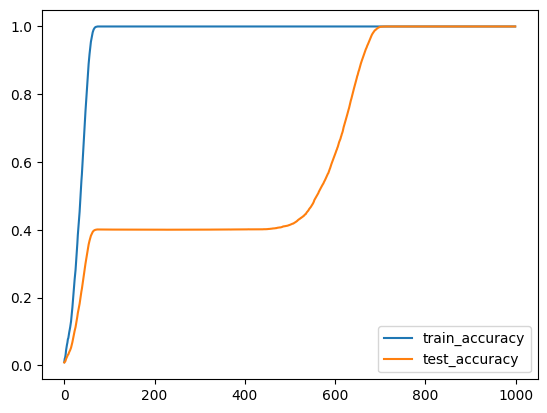

In [429]:
fig = trainer.plot_accuracy()

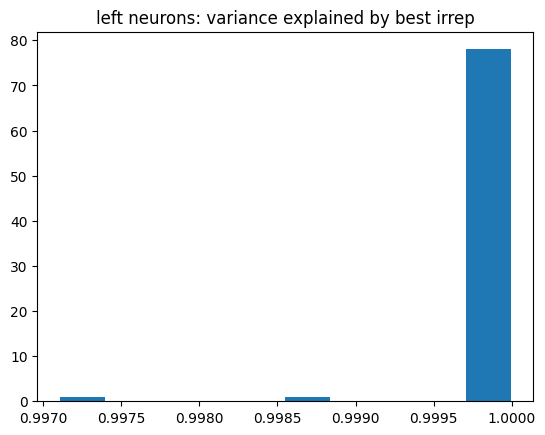

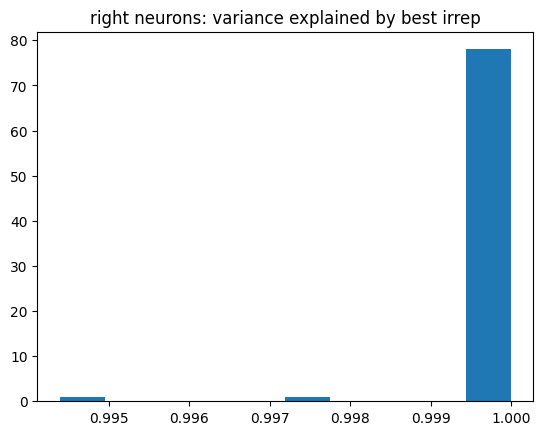

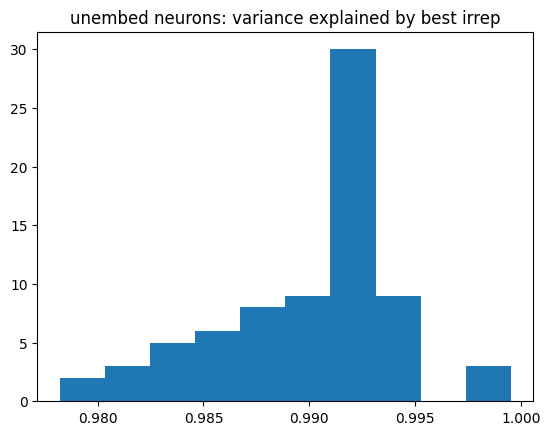

In [431]:
trainer.print_expl_clusters(norm_thresh=0.5)

In [432]:
# print the number of neurons in each irrep
x = trainer.irrep_idx_dict(
    thresh=0.95, norm_thresh=0.05, cluster_id=0, neuron_type="left"
)
for k, v in x.items():
    print(k, len(v))

1d-0 3
4d-0 0
5d-0 0
6d-0 0
5d-1 0
4d-1 81
1d-1 0
none 44


### 2. Cyclic case

In [ ]:
group = Group.from_gap(gap.CyclicGroup(113))


params = ParametersBasic(group=group, embed_dimensions=(64,), hidden_dimensions=(64,))

trainer = MLPTrainer(params=params)

trainer.train(epochs=1000)

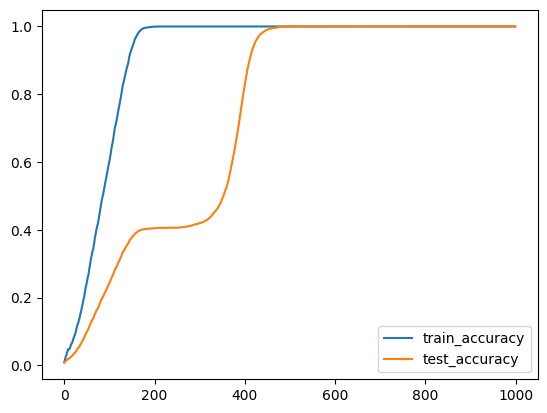

In [443]:
fig = trainer.plot_accuracy()

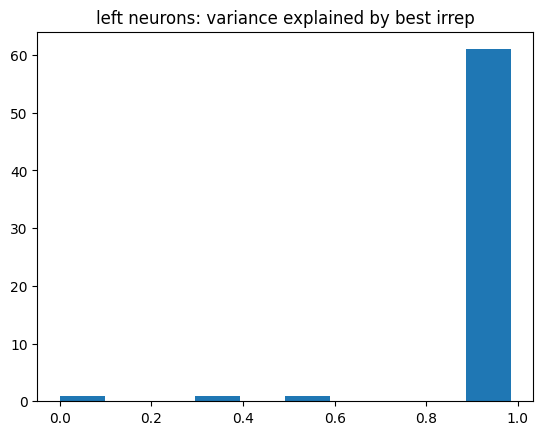

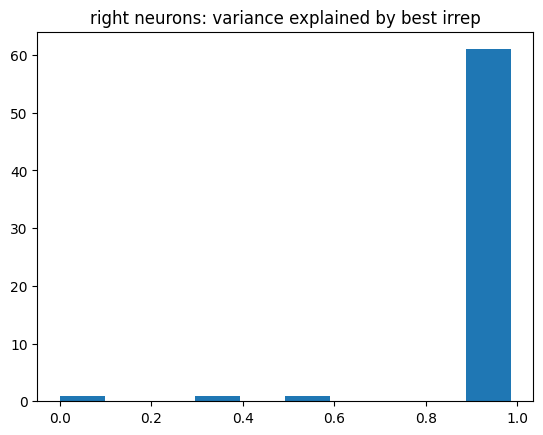

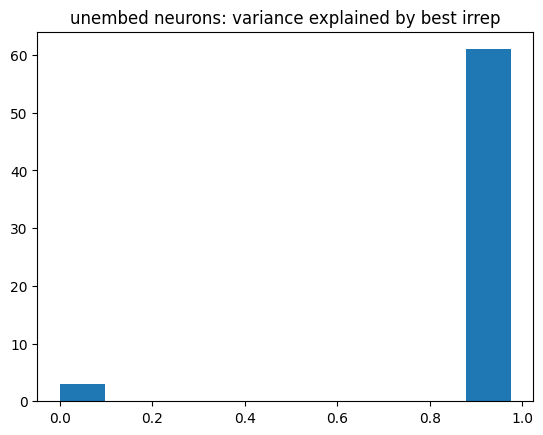

In [444]:
trainer.print_expl_clusters()

In [452]:
import torch

p = 113
fourier_basis = []
fourier_basis.append(torch.ones(p) / np.sqrt(p))
fourier_basis_names = ["Const"]
# Note that if p is even, we need to explicitly add a term for cos(kpi), ie
# alternating +1 and -1
for i in range(1, p // 2 + 1):
    fourier_basis.append(torch.cos(2 * torch.pi * torch.arange(p) * i / p))
    fourier_basis.append(torch.sin(2 * torch.pi * torch.arange(p) * i / p))
    fourier_basis[-2] /= fourier_basis[-2].norm()
    fourier_basis[-1] /= fourier_basis[-1].norm()
    fourier_basis_names.append(f"cos {i}")
    fourier_basis_names.append(f"sin {i}")
fourier_basis = torch.stack(fourier_basis, dim=0).to("mps")

In [453]:
irrep_idx_dict = trainer.irrep_idx_dict(thresh=0.95, cluster_id=0, neuron_type="left")
for k, v in irrep_idx_dict.items():
    if len(v) > 0:
        print(k, len(v))

2d-19 10
2d-31 15
2d-33 8
2d-47 16
2d-54 12
2d-57 12
2d-64 16
2d-78 8
2d-80 15
2d-92 10
none 3


In [454]:
for k, v in irrep_idx_dict.items():
    if len(v) > 0:
        print(k, len(v))

2d-19 10
2d-31 15
2d-33 8
2d-47 16
2d-54 12
2d-57 12
2d-64 16
2d-78 8
2d-80 15
2d-92 10
none 3


tensor(63, device='mps:0')


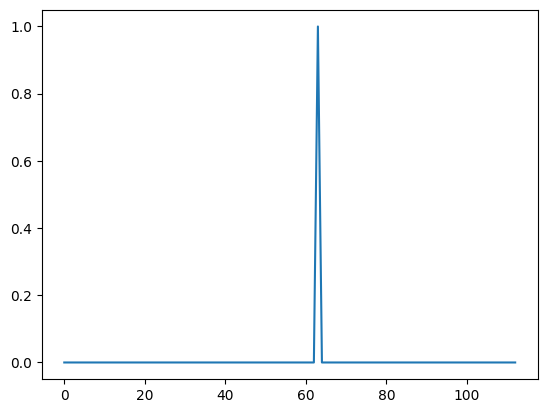

In [455]:
irrep_bases = trainer.get_irrep_basis()

# convert from gap to fourier basis indices
x = (irrep_bases["2d-31"][:, 0].unsqueeze(1).T @ fourier_basis.T).pow(2).sum(0)

plt.plot(x.cpu().numpy())
print(x.argmax())

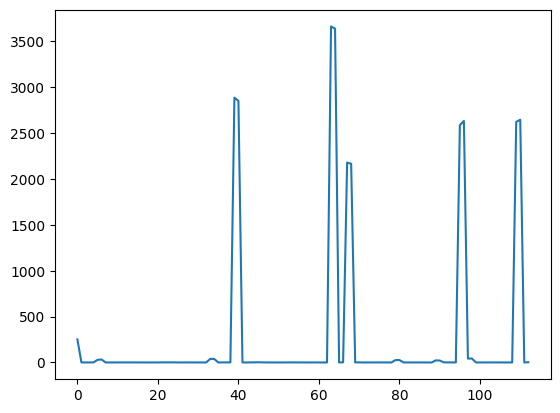

In [563]:
lneurons, rneurons, uneurons = trainer.clusters[0].get_neurons(squeeze=True)
# sanity check fourier basis
fourier_norms = (lneurons.T @ fourier_basis.T).pow(2).sum(0)
plt.plot(fourier_norms.cpu().numpy())

In [567]:
best_modes = fourier_norms.sort()[1][-10:] // 2

In [ ]:
# compute basis coefficients in fourier basis
z = lneurons[:, 5].unsqueeze(1).T @ fourier_basis.T
z = z.cpu().detach().numpy()
plt.plot(z[0])

In [464]:
self = trainer
part = "embedding_left"
inputs = t.tensor(t.arange(0, len(self.group)), device=mps_device, dtype=t.int)
if part == "embedding_left":
    embeddings = self.clusters[0].embedding_left(inputs)  # [N, embedding]
elif part == "embedding_right":
    embeddings = self.clusters[0].embedding_right(inputs)  # [N, embedding]

/var/folders/wb/vkfyyjp93y921cb9ngfqvyxm0000gn/T/ipykernel_47363/365586328.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = t.tensor(t.arange(0, len(self.group)), device=mps_device, dtype=t.int)


In [466]:
embeddings.shape

torch.Size([113, 64])

In [508]:
fourier_basis[1]

tensor([ 0.1330,  0.1328,  0.1322,  0.1312,  0.1298,  0.1279,  0.1257,  0.1231,
         0.1201,  0.1167,  0.1130,  0.1089,  0.1045,  0.0998,  0.0947,  0.0894,
         0.0838,  0.0779,  0.0718,  0.0654,  0.0589,  0.0522,  0.0453,  0.0383,
         0.0311,  0.0239,  0.0166,  0.0092,  0.0018, -0.0055, -0.0129, -0.0203,
        -0.0275, -0.0347, -0.0418, -0.0488, -0.0556, -0.0622, -0.0686, -0.0749,
        -0.0809, -0.0866, -0.0921, -0.0973, -0.1022, -0.1068, -0.1110, -0.1149,
        -0.1185, -0.1216, -0.1244, -0.1269, -0.1289, -0.1305, -0.1318, -0.1326,
        -0.1330, -0.1330, -0.1326, -0.1318, -0.1305, -0.1289, -0.1269, -0.1244,
        -0.1216, -0.1185, -0.1149, -0.1110, -0.1068, -0.1022, -0.0973, -0.0921,
        -0.0866, -0.0809, -0.0749, -0.0686, -0.0622, -0.0556, -0.0488, -0.0418,
        -0.0347, -0.0275, -0.0203, -0.0129, -0.0055,  0.0018,  0.0092,  0.0166,
         0.0239,  0.0311,  0.0383,  0.0453,  0.0522,  0.0589,  0.0654,  0.0718,
         0.0779,  0.0838,  0.0894,  0.09

In [526]:
fourier_basis[1]

tensor([ 0.1330,  0.1328,  0.1322,  0.1312,  0.1298,  0.1279,  0.1257,  0.1231,
         0.1201,  0.1167,  0.1130,  0.1089,  0.1045,  0.0998,  0.0947,  0.0894,
         0.0838,  0.0779,  0.0718,  0.0654,  0.0589,  0.0522,  0.0453,  0.0383,
         0.0311,  0.0239,  0.0166,  0.0092,  0.0018, -0.0055, -0.0129, -0.0203,
        -0.0275, -0.0347, -0.0418, -0.0488, -0.0556, -0.0622, -0.0686, -0.0749,
        -0.0809, -0.0866, -0.0921, -0.0973, -0.1022, -0.1068, -0.1110, -0.1149,
        -0.1185, -0.1216, -0.1244, -0.1269, -0.1289, -0.1305, -0.1318, -0.1326,
        -0.1330, -0.1330, -0.1326, -0.1318, -0.1305, -0.1289, -0.1269, -0.1244,
        -0.1216, -0.1185, -0.1149, -0.1110, -0.1068, -0.1022, -0.0973, -0.0921,
        -0.0866, -0.0809, -0.0749, -0.0686, -0.0622, -0.0556, -0.0488, -0.0418,
        -0.0347, -0.0275, -0.0203, -0.0129, -0.0055,  0.0018,  0.0092,  0.0166,
         0.0239,  0.0311,  0.0383,  0.0453,  0.0522,  0.0589,  0.0654,  0.0718,
         0.0779,  0.0838,  0.0894,  0.09

In [529]:
i = 1
x = torch.cos(2 * torch.pi * torch.arange(p) * i / p).to(mps_device)
x /= x.norm()
x - fourier_basis[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [530]:
i = 1
x = torch.sin(2 * torch.pi * torch.arange(p) * i / p).to(mps_device)
x /= x.norm()
x - fourier_basis[2]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')

In [554]:
x = fourier_basis[1:]
d = x.shape[0]
y = einops.rearrange(x, "(k two) p -> k two p", two=2)

In [634]:
fourier_basis[1], fourier_basis[2]

(tensor([ 0.1330,  0.1328,  0.1322,  0.1312,  0.1298,  0.1279,  0.1257,  0.1231,
          0.1201,  0.1167,  0.1130,  0.1089,  0.1045,  0.0998,  0.0947,  0.0894,
          0.0838,  0.0779,  0.0718,  0.0654,  0.0589,  0.0522,  0.0453,  0.0383,
          0.0311,  0.0239,  0.0166,  0.0092,  0.0018, -0.0055, -0.0129, -0.0203,
         -0.0275, -0.0347, -0.0418, -0.0488, -0.0556, -0.0622, -0.0686, -0.0749,
         -0.0809, -0.0866, -0.0921, -0.0973, -0.1022, -0.1068, -0.1110, -0.1149,
         -0.1185, -0.1216, -0.1244, -0.1269, -0.1289, -0.1305, -0.1318, -0.1326,
         -0.1330, -0.1330, -0.1326, -0.1318, -0.1305, -0.1289, -0.1269, -0.1244,
         -0.1216, -0.1185, -0.1149, -0.1110, -0.1068, -0.1022, -0.0973, -0.0921,
         -0.0866, -0.0809, -0.0749, -0.0686, -0.0622, -0.0556, -0.0488, -0.0418,
         -0.0347, -0.0275, -0.0203, -0.0129, -0.0055,  0.0018,  0.0092,  0.0166,
          0.0239,  0.0311,  0.0383,  0.0453,  0.0522,  0.0589,  0.0654,  0.0718,
          0.0779,  0.0838,  

In [640]:
fourier_basis[0].shape

torch.Size([113])

In [641]:
embeddings.shape

torch.Size([113, 64])

In [643]:
embeddings[0].shape

torch.Size([64])

In [705]:
(fourier_basis[40] @ embeddings).norm()

tensor(6.1381)

In [706]:
embeddings.shape

torch.Size([113, 64])

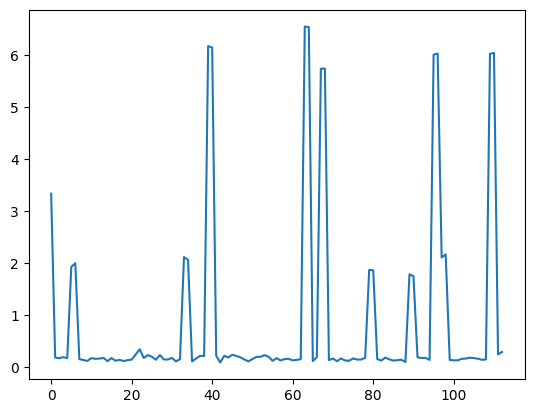

In [701]:
fourier_norms = (fourier_basis @ embeddings).norm(dim=1)
plt.plot(fourier_norms)

In [714]:
# unit vector of shape 113 with entry 1 at 0 th position
unit_vector = torch.zeros(113)
unit_vector[0] = 1

fourier_basis @ embeddings

tensor([[ 0.3235, -0.9341, -0.0906,  ...,  0.2320,  0.9073, -0.6309],
        [-0.0287, -0.0257,  0.0475,  ..., -0.0263, -0.0110, -0.0370],
        [-0.0186, -0.0243,  0.0118,  ...,  0.0132,  0.0151, -0.0111],
        ...,
        [-0.6267,  1.0556, -0.0500,  ..., -0.9730, -0.4818, -0.2378],
        [ 0.0367,  0.0035,  0.0143,  ..., -0.0211, -0.0296, -0.0212],
        [-0.0431, -0.0121,  0.0284,  ..., -0.0288,  0.0506,  0.0495]])

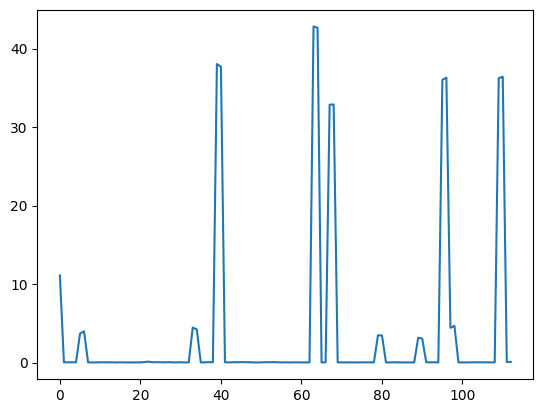

In [692]:
fourier_norms = (fourier_basis @ embeddings).T.pow(2).sum(0)
plt.plot(fourier_norms)

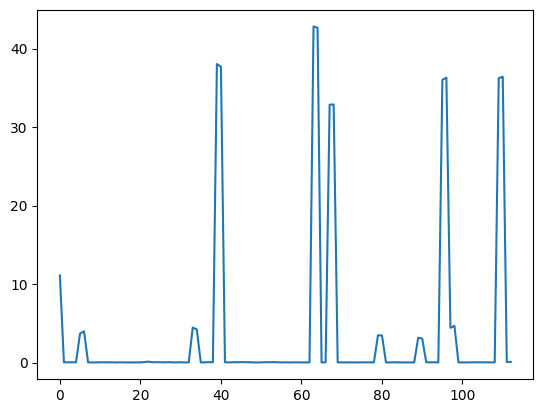

In [687]:
fourier_norms = (embeddings.T @ fourier_basis.T).pow(2).sum(0)
plt.plot(fourier_norms.cpu().numpy())

In [575]:
y[0].shape

torch.Size([2, 113])

In [577]:
(embeddings @ embeddings.T)

torch.Size([113, 113])

In [772]:
(fourier_basis @ embeddings).shape

torch.Size([113, 64])

In [788]:
from matplotlib.colors import Normalize

from matplotlib.cm import ScalarMappable


def get_dft_matrix(P):
    cos = t.zeros((P, P))
    sin = t.zeros((P, P))
    for i in range(P):
        for j in range(P):
            theta = t.tensor(2 * t.pi * i * j / P)
            cos[i, j] = t.cos(theta)
            sin[i, j] = t.sin(theta)
    return cos, sin


def get_magnitude_modes(weights, P):
    cos, sin = get_dft_matrix(P)
    c1, s1 = cos @ weights, sin @ weights
    return t.sqrt(t.sum(c1**2 + s1**2, dim=-1))


def get_weights_modes(weights, P):
    cos, sin = get_dft_matrix(P)
    c1 = cos @ (weights @ weights.T)
    s1 = sin @ (weights @ weights.T)
    return c1, s1


def viz_weights_modes(weights, P, fname, title="Modes"):
    c1, s1 = get_weights_modes(weights, P)
    mags = get_magnitude_modes(weights, P)
    n_plots = (P // 2) + 1
    num_cols = int(math.ceil(math.sqrt(n_plots)))
    num_rows = int(math.ceil(n_plots / num_cols))
    colormap = plt.cm.rainbow
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    colors = [colormap(i) for i in np.linspace(0, 1, P)]
    for mode in range(n_plots):
        cos = c1[mode]
        sin = s1[mode]
        plt.subplot(num_rows, num_cols, mode + 1)
        color_idx = [(i * mode) % P for i in range(P)]
        color_for_mode = [colors[idx] for idx in color_idx]
        plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
        plt.title(f"Mode {mode} {mags[mode]:.4f}", fontsize=8)
    plt.suptitle(title)
    norm = Normalize(vmin=0, vmax=P)
    sm = ScalarMappable(cmap=colormap, norm=norm)
    cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
    plt.colorbar(sm, cax=cbar_ax)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(fname)
    plt.close()

In [789]:
viz_weights_modes(embeddings.cpu().detach(), 113, "test.png")

/var/folders/wb/vkfyyjp93y921cb9ngfqvyxm0000gn/T/ipykernel_47363/2980027147.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


In [757]:
P = 113

cos, sin = get_dft_matrix(P)

embeddings = embeddings.cpu().detach()

In [758]:
(
    c_1,
    s_1,
) = get_weights_modes(embeddings, P)

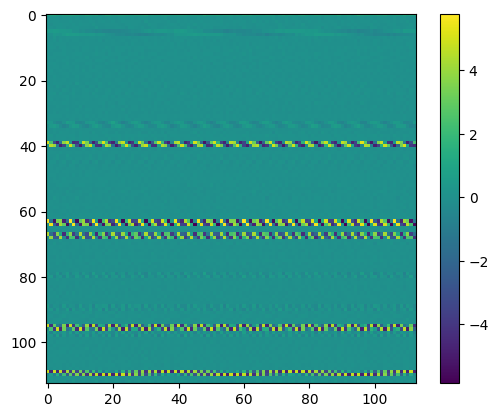

In [770]:
m = fourier_basis @ embeddings @ embeddings.T
# plot m with colour scale
plt.imshow(m, cmap="viridis")
plt.colorbar()

In [762]:
c_1[0]

tensor([12.5310, 12.6350, 13.9488,  9.8028,  9.3723, 11.8134, 11.7395, 13.0050,
        13.1753, 11.0399,  9.7198, 10.5898, 13.4645, 11.0147, 10.7981, 12.5063,
         6.4675,  9.5591, 13.7453, 13.3746, 10.4644, 11.0245, 13.1555, 12.6403,
        11.5865, 10.6066,  9.3590, 12.1943, 11.8664, 13.1140, 14.2688,  9.3848,
        10.4498,  8.5561,  9.4257, 11.3862, 11.7562, 11.9003,  8.4130, 10.1516,
        10.3171, 12.3710, 11.4554,  8.9501, 10.8960, 10.7989,  8.3422, 10.5611,
        15.1064, 12.0470, 11.5303, 12.0717, 12.8825,  9.5224, 11.7714, 11.4739,
        12.0914,  9.9438, 11.3074,  9.5401, 13.7361, 11.2386, 13.5761, 10.2202,
        10.9650, 10.6744, 10.1921, 11.9080, 11.4304, 10.6185,  6.4761, 11.1286,
        13.5030,  9.1259, 11.7440, 10.1752,  7.5113, 12.2434, 13.6648, 10.0489,
         8.9489,  9.5103, 12.1973, 11.3825,  9.6100, 10.3283,  9.7842,  9.4642,
         9.4500, 13.7208,  8.3649, 10.2898, 10.7618,  7.9595, 11.0449, 15.6896,
        13.0701, 11.9664, 11.3322,  9.74

In [661]:
fourier_basis = fourier_basis.cpu().detach()

In [746]:
# save 39 and 40

In [782]:
(fourier_basis @ embeddings)

tensor([[ 0.3235, -0.9341, -0.0906,  ...,  0.2320,  0.9073, -0.6309],
        [-0.0287, -0.0257,  0.0475,  ..., -0.0263, -0.0110, -0.0370],
        [-0.0186, -0.0243,  0.0118,  ...,  0.0132,  0.0151, -0.0111],
        ...,
        [-0.6267,  1.0556, -0.0500,  ..., -0.9730, -0.4818, -0.2378],
        [ 0.0367,  0.0035,  0.0143,  ..., -0.0211, -0.0296, -0.0212],
        [-0.0431, -0.0121,  0.0284,  ..., -0.0288,  0.0506,  0.0495]])

In [ ]:
k = 32
f_39 = fourier_basis[2 * k - 1] @ embeddings
f_40 = fourier_basis[2 * k] @ embeddings
z_0 = f_39 @ embeddings.T
z_1 = f_40 @ embeddings.T
labels = [f"{i}" for i in range(113)]
plt.figure(figsize=(20, 20))
plt.scatter(z_0, z_1)
for i, txt in enumerate(labels):
    plt.annotate(txt, (z_0[i], z_1[i]))

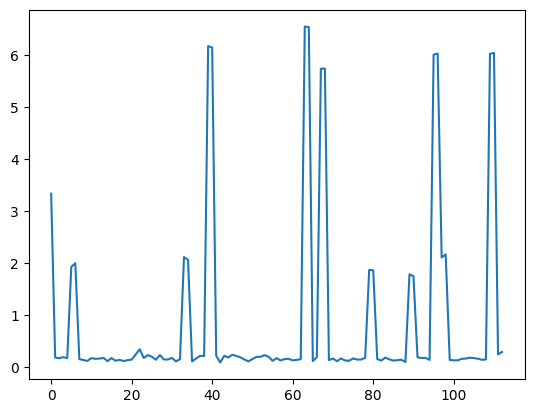

In [739]:
f = (fourier_basis @ embeddings).norm(dim=1)
plt.plot(f)

In [675]:
(fourier_basis @ embeddings).norm(dim=1)

tensor([3.3301, 0.1791, 0.1673, 0.1870, 0.1686, 1.9206, 1.9942, 0.1493, 0.1318,
        0.1145, 0.1691, 0.1552, 0.1591, 0.1731, 0.1102, 0.1694, 0.1181, 0.1354,
        0.1132, 0.1300, 0.1399, 0.2375, 0.3397, 0.1718, 0.2260, 0.1967, 0.1382,
        0.2274, 0.1425, 0.1418, 0.1727, 0.1062, 0.1486, 2.1110, 2.0560, 0.1052,
        0.1616, 0.2127, 0.2096, 6.1667, 6.1381, 0.2142, 0.0850, 0.2119, 0.1818,
        0.2332, 0.2103, 0.1844, 0.1423, 0.1066, 0.1511, 0.1932, 0.1938, 0.2260,
        0.1958, 0.1169, 0.1684, 0.1234, 0.1513, 0.1551, 0.1252, 0.1347, 0.1486,
        6.5434, 6.5308, 0.1126, 0.1872, 5.7323, 5.7336, 0.1310, 0.1618, 0.1092,
        0.1616, 0.1226, 0.1183, 0.1627, 0.1405, 0.1417, 0.1730, 1.8645, 1.8560,
        0.1508, 0.1214, 0.1792, 0.1446, 0.1208, 0.1295, 0.1387, 0.0943, 1.7786,
        1.7431, 0.1843, 0.1711, 0.1732, 0.1353, 6.0006, 6.0246, 2.1031, 2.1623,
        0.1346, 0.1265, 0.1263, 0.1548, 0.1614, 0.1778, 0.1687, 0.1573, 0.1364,
        0.1444, 6.0182, 6.0337, 0.2414, 

In [663]:
cos @ embeddings

tensor([[ 3.4393, -9.9295, -0.9628,  ...,  2.4661,  9.6450, -6.7069],
        [-0.2159, -0.1931,  0.3571,  ..., -0.1974, -0.0825, -0.2778],
        [ 0.2792, -0.1295, -0.0147,  ...,  0.2525, -0.0446, -0.2550],
        ...,
        [ 0.9126, -0.1085,  0.0551,  ..., -4.1946,  1.4716,  0.3033],
        [ 0.2792, -0.1295, -0.0147,  ...,  0.2525, -0.0447, -0.2550],
        [-0.2159, -0.1931,  0.3571,  ..., -0.1974, -0.0826, -0.2778]])

In [ ]:
for k in range(d // 2):
    z = (
        einops.einsum(y[k].detach().cpu(), embeddings.detach().cpu(), "n p,p N -> n N")
        .T.detach()
        .cpu()
        .numpy()
    )

    plt.scatter(z[:, 0], z[:, 1])
    plt.title(f"Fourier basis {k}")
    plt.show()

In [628]:
g = lambda r: (z[r, 0], z[r, 1])

In [631]:
g(0)

(np.float32(0.022516392), np.float32(-0.16142452))

In [630]:
g(1)

(np.float32(0.13900213), np.float32(0.13130212))

/var/folders/wb/vkfyyjp93y921cb9ngfqvyxm0000gn/T/ipykernel_47363/3134276041.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(z[:, 0], z[:, 1], c=colors[i])


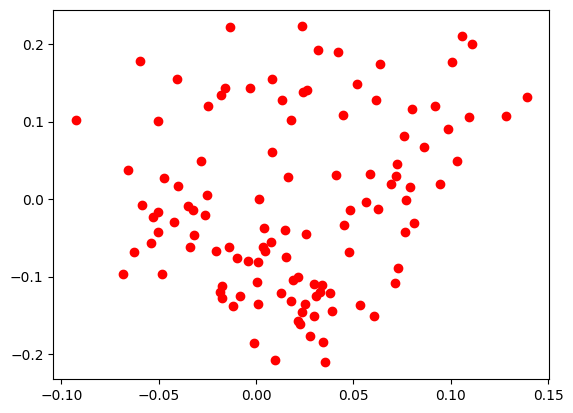

In [604]:
plt.plot()
plt.scatter(z[:, 0], z[:, 1], c=colors[i])

In [500]:
z.T[0]

tensor([-0.0210, -0.0431], device='mps:0', grad_fn=<SelectBackward0>)

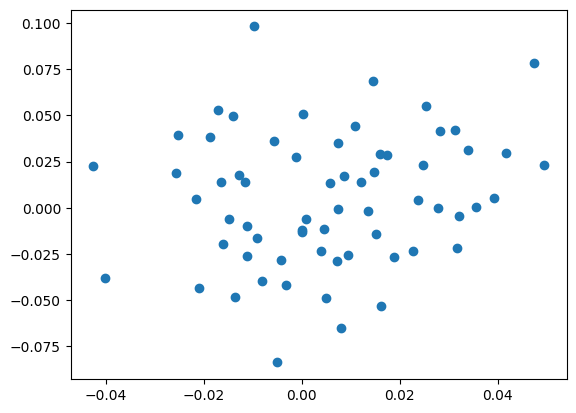

### 3. Spiral


In [ ]:
group = 